In [24]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
#from livelossplot import PlotLosses

In [2]:
# generic to specifiy if gpu or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
train_path = "E:/1TB_disk/Dane/Projekty/DataScience/ML/transfer_learning/omega3/train"
val_path = "E:/1TB_disk/Dane/Projekty/DataScience/ML/transfer_learning/omega3/validation"

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(train_path, data_transforms['train']),
    'validation': 
    datasets.ImageFolder(val_path, data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False, num_workers=4)
}

In [11]:
# if on CPU, uncomment some lines... unless you are VERY patient

def train_model(model, criterion, optimizer, num_epochs=10):
    #liveloss = PlotLosses(skip_first=0)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # current_step = 0
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # print(current_step, end=" ")

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()
                # current_step += inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        #liveloss.update(logs)
        #liveloss.draw()

In [4]:
# loading the model
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.Dropout(0.25),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Adam/.cache\torch\checkpoints\resnet50-19c8e357.pth
100.0%


In [8]:
# defining loss function and optimization algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [12]:
train_model(model, criterion, optimizer, num_epochs=5)

In [30]:
validation_img_paths = [val_path+"/avocado/avocado-toasts-on-rye-bread-royalty-free-image-1005124106-1558015377.jpg",
                        val_path+"/salmon/11735173529630.jpg",
                        val_path+"/omega3/10615610-1-025241.jpg",
                        val_path+"/avocado/Avocado-Rose-1.jpg"]

img_list = [Image.open(img_path) for img_path in validation_img_paths]


In [34]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [35]:
pred_logits_tensor = model(validation_batch)
pred_probs = pred_logits_tensor.softmax(dim=1).cpu().data.numpy()
pred_probs

array([[6.5930080e-01, 9.9352911e-02, 2.3892145e-01, 2.4248352e-03],
       [2.9732493e-01, 5.3187039e-02, 6.4893401e-01, 5.5408024e-04],
       [1.8529084e-01, 7.1202779e-01, 1.0191250e-01, 7.6884549e-04],
       [6.9186366e-01, 1.2511243e-01, 1.8261108e-01, 4.1286144e-04]],
      dtype=float32)

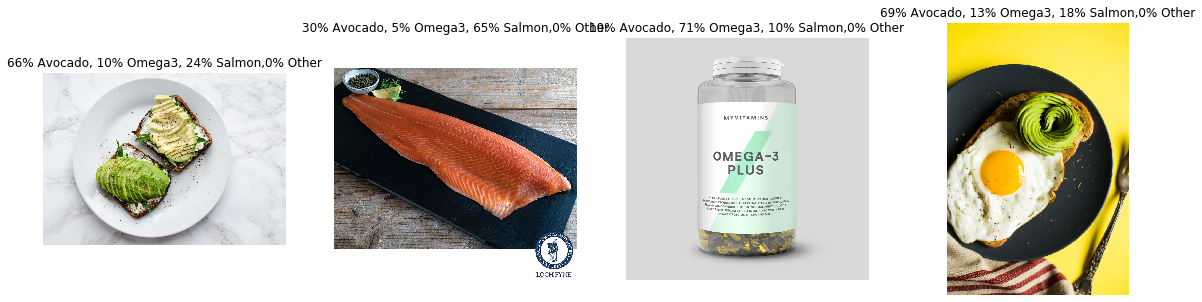

In [36]:
# make it more generig with classes
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Avocado, {:.0f}% Omega3, {:.0f}% Salmon,{:.0f}% Other".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1],
                                                          100*pred_probs[i,2],
                                                          100*pred_probs[i,3]))
    ax.imshow(img)